In [2]:
from IPython.display import Image

# **Projekt na zajęcia Algorytmy Uczenia Maszynowego, prowadzący dr. inż Piotr Ciskowski**
# **Twórcy: Adam Kubiak i Piotr Gorzelnik**
# **Projekt: Rozpoznawanie podstaw języka migowego w czasie rzeczywistym**

W ramach projektu wykorzystaliśmy zbiór danych, złożony z zdjęć dłoni, która reprezentuje jedną z 24 liter języka migowego(W alfabecie znajduje się 26 liter jednak litera "J" oraz "Z" jest reprezentowana poprzez ruch dłonią co wykracza poza założenia projektu). Zbiór danych zostaje wykorzystany do uczenia modelu Convolutional Neural Networks (CNN), Sequential, który jest dostępny w pakiecie o nazwie "keras". Dane uzykane zostały ze strony kaggle.com. Są one udostępnione w formie pliku .csv gdzie każdy pixel jest reprezentowany przez liczbe z zakresu 0-255, każde zdjęcie składa się z 784 pixeli(wymiary 28x28). Dodatkowo dołożyliśmy kilka dodatkowych znaków do wykorzystywanego zbioru danych. Projekt spełnia następujące zadania:

- Przygotowanie zbioru danych
- Przetworzenie zbioru aby spełniał wymagania modelu Sequential
- Przygotowanie modelu i ustawienie odpowiednich wartości jego parametrów
- Nauka modelu
- Sprawdzenie dokładności modelu z wykrzystaniem zbioru testowego danych
- Wykorzystanie biblioteki CV2 w celu zbierania zdjęć z kamery 
- Przetworznie pobranego obrazu z kamery
- Estymacja pokazywanego znaku przez użytkownika z wykorzystaniem wyuczonego modelu CNN

# ![title](ImagesNotebook\American-Sign-Language-alphabet-community-used-including-letters-from-A-to-Y-excluding.png)



#  **Importowanie pakietów wykorzystanych w projekcie**

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy
import cv2
import os
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# **Ładowanie i wstępne przetwarzanie zbioru danych**
Format zestawu danych jest wzorowany, aby ściśle odpowiadał klasycznemu MNIST. Każdy przypadek treningowy i testowy reprezentuje etykietę (0-25) jako mapę jeden do jednego dla każdej litery alfabetu A-Z (nie ma przypadków dla 9=J lub 25=Z ze względu na ruchy gestów). Dane treningowe (27 455 przypadków) i dane testowe (7172 przypadki). Wiersz danych w pliku .csv zawiera etykiete oraz pixel1,pixel2….pixel784, które w całości reprezentują pojedynczy obraz 28x28 pikseli z wartości w skali szarości z zakresu 0-255. Dodatkowe etykiety wybranych przez nas znaków są przetwarzane za pomocą napisanej funkcji, która bada wszystkie zdjęcia znajdujące się w podanym przez użytkownika folderze, a następnie przetwarza je do odpowiedniego formatu narzuconego przez podstawowy zbiór danych wraz z etykietą przypisaną przez użytkownika.


In [4]:
train_df=pd.read_csv('kaggle\sign_mnist_train.csv')
test_df=pd.read_csv('kaggle\sign_mnist_test.csv')


Prezentacja formatu pobranych danych z pliku .csv do struktury danych DataFrame z pakietu Pandas

In [5]:
train_df.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93
27454,23,179,180,180,180,182,181,182,183,182,...,108,132,170,194,214,203,197,205,209,215


Etykiety znajdujące się w DataFrame przed dodaniem własnych znaków do zbioru danych

In [6]:
df = train_df.iloc[:,0]
print(train_df.iloc[:,0].unique())

[ 3  6  2 13 16  8 22 18 10 20 17 19 21 23 24  1 12 11 15  4  0  5  7 14]


Funkcja mająca na celu przetworzenie zdjęć z dodatkowymi znakami języka migowego do formatu istniejącego DataFrame

In [7]:
def addDataToSet(path_folder, label_):
    i = 0
    path = os.path.join(path_folder)
    rows = len(os.listdir(path))
    finalImageList = np.zeros(shape=(rows,785))
    while i < len(os.listdir(path)):
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = np.mean(img_array,-1)
            #print(img.shape)
            img_array = scipy.ndimage.zoom(img_array,1/124)
            #plt.imshow(img_array, cmap='gray')
            img_array = img_array.reshape((1,784))
            img_array = np.insert(img_array, 0, int(label_), axis=1) # label
            img_array = np.around(img_array,decimals=0)
            img_array = img_array.astype(int)
            finalImageList[i] = (img_array)
            i+=1
    return finalImageList

Dołączenie dodatkowych znaków do zbioru uczącego

In [8]:
Datadirectory = "FAK"
label = 9
df = pd.DataFrame(addDataToSet(Datadirectory,label), columns = ['label','pixel1','pixel2','pixel3','pixel4','pixel5','pixel6','pixel7','pixel8','pixel9','pixel10','pixel11','pixel12','pixel13','pixel14','pixel15','pixel16','pixel17','pixel18','pixel19','pixel20','pixel21','pixel22','pixel23','pixel24','pixel25','pixel26','pixel27','pixel28','pixel29','pixel30','pixel31','pixel32','pixel33','pixel34','pixel35','pixel36','pixel37','pixel38','pixel39','pixel40','pixel41','pixel42','pixel43','pixel44','pixel45','pixel46','pixel47','pixel48','pixel49','pixel50','pixel51','pixel52','pixel53','pixel54','pixel55','pixel56','pixel57','pixel58','pixel59','pixel60','pixel61','pixel62','pixel63','pixel64','pixel65','pixel66','pixel67','pixel68','pixel69','pixel70','pixel71','pixel72','pixel73','pixel74','pixel75','pixel76','pixel77','pixel78','pixel79','pixel80','pixel81','pixel82','pixel83','pixel84','pixel85','pixel86','pixel87','pixel88','pixel89','pixel90','pixel91','pixel92','pixel93','pixel94','pixel95','pixel96','pixel97','pixel98','pixel99','pixel100','pixel101','pixel102','pixel103','pixel104','pixel105','pixel106','pixel107','pixel108','pixel109','pixel110','pixel111','pixel112','pixel113','pixel114','pixel115','pixel116','pixel117','pixel118','pixel119','pixel120','pixel121','pixel122','pixel123','pixel124','pixel125','pixel126','pixel127','pixel128','pixel129','pixel130','pixel131','pixel132','pixel133','pixel134','pixel135','pixel136','pixel137','pixel138','pixel139','pixel140','pixel141','pixel142','pixel143','pixel144','pixel145','pixel146','pixel147','pixel148','pixel149','pixel150','pixel151','pixel152','pixel153','pixel154','pixel155','pixel156','pixel157','pixel158','pixel159','pixel160','pixel161','pixel162','pixel163','pixel164','pixel165','pixel166','pixel167','pixel168','pixel169','pixel170','pixel171','pixel172','pixel173','pixel174','pixel175','pixel176','pixel177','pixel178','pixel179','pixel180','pixel181','pixel182','pixel183','pixel184','pixel185','pixel186','pixel187','pixel188','pixel189','pixel190','pixel191','pixel192','pixel193','pixel194','pixel195','pixel196','pixel197','pixel198','pixel199','pixel200','pixel201','pixel202','pixel203','pixel204','pixel205','pixel206','pixel207','pixel208','pixel209','pixel210','pixel211','pixel212','pixel213','pixel214','pixel215','pixel216','pixel217','pixel218','pixel219','pixel220','pixel221','pixel222','pixel223','pixel224','pixel225','pixel226','pixel227','pixel228','pixel229','pixel230','pixel231','pixel232','pixel233','pixel234','pixel235','pixel236','pixel237','pixel238','pixel239','pixel240','pixel241','pixel242','pixel243','pixel244','pixel245','pixel246','pixel247','pixel248','pixel249','pixel250','pixel251','pixel252','pixel253','pixel254','pixel255','pixel256','pixel257','pixel258','pixel259','pixel260','pixel261','pixel262','pixel263','pixel264','pixel265','pixel266','pixel267','pixel268','pixel269','pixel270','pixel271','pixel272','pixel273','pixel274','pixel275','pixel276','pixel277','pixel278','pixel279','pixel280','pixel281','pixel282','pixel283','pixel284','pixel285','pixel286','pixel287','pixel288','pixel289','pixel290','pixel291','pixel292','pixel293','pixel294','pixel295','pixel296','pixel297','pixel298','pixel299','pixel300','pixel301','pixel302','pixel303','pixel304','pixel305','pixel306','pixel307','pixel308','pixel309','pixel310','pixel311','pixel312','pixel313','pixel314','pixel315','pixel316','pixel317','pixel318','pixel319','pixel320','pixel321','pixel322','pixel323','pixel324','pixel325','pixel326','pixel327','pixel328','pixel329','pixel330','pixel331','pixel332','pixel333','pixel334','pixel335','pixel336','pixel337','pixel338','pixel339','pixel340','pixel341','pixel342','pixel343','pixel344','pixel345','pixel346','pixel347','pixel348','pixel349','pixel350','pixel351','pixel352','pixel353','pixel354','pixel355','pixel356','pixel357','pixel358','pixel359','pixel360','pixel361','pixel362','pixel363','pixel364','pixel365','pixel366','pixel367','pixel368','pixel369','pixel370','pixel371','pixel372','pixel373','pixel374','pixel375','pixel376','pixel377','pixel378','pixel379','pixel380','pixel381','pixel382','pixel383','pixel384','pixel385','pixel386','pixel387','pixel388','pixel389','pixel390','pixel391','pixel392','pixel393','pixel394','pixel395','pixel396','pixel397','pixel398','pixel399','pixel400','pixel401','pixel402','pixel403','pixel404','pixel405','pixel406','pixel407','pixel408','pixel409','pixel410','pixel411','pixel412','pixel413','pixel414','pixel415','pixel416','pixel417','pixel418','pixel419','pixel420','pixel421','pixel422','pixel423','pixel424','pixel425','pixel426','pixel427','pixel428','pixel429','pixel430','pixel431','pixel432','pixel433','pixel434','pixel435','pixel436','pixel437','pixel438','pixel439','pixel440','pixel441','pixel442','pixel443','pixel444','pixel445','pixel446','pixel447','pixel448','pixel449','pixel450','pixel451','pixel452','pixel453','pixel454','pixel455','pixel456','pixel457','pixel458','pixel459','pixel460','pixel461','pixel462','pixel463','pixel464','pixel465','pixel466','pixel467','pixel468','pixel469','pixel470','pixel471','pixel472','pixel473','pixel474','pixel475','pixel476','pixel477','pixel478','pixel479','pixel480','pixel481','pixel482','pixel483','pixel484','pixel485','pixel486','pixel487','pixel488','pixel489','pixel490','pixel491','pixel492','pixel493','pixel494','pixel495','pixel496','pixel497','pixel498','pixel499','pixel500','pixel501','pixel502','pixel503','pixel504','pixel505','pixel506','pixel507','pixel508','pixel509','pixel510','pixel511','pixel512','pixel513','pixel514','pixel515','pixel516','pixel517','pixel518','pixel519','pixel520','pixel521','pixel522','pixel523','pixel524','pixel525','pixel526','pixel527','pixel528','pixel529','pixel530','pixel531','pixel532','pixel533','pixel534','pixel535','pixel536','pixel537','pixel538','pixel539','pixel540','pixel541','pixel542','pixel543','pixel544','pixel545','pixel546','pixel547','pixel548','pixel549','pixel550','pixel551','pixel552','pixel553','pixel554','pixel555','pixel556','pixel557','pixel558','pixel559','pixel560','pixel561','pixel562','pixel563','pixel564','pixel565','pixel566','pixel567','pixel568','pixel569','pixel570','pixel571','pixel572','pixel573','pixel574','pixel575','pixel576','pixel577','pixel578','pixel579','pixel580','pixel581','pixel582','pixel583','pixel584','pixel585','pixel586','pixel587','pixel588','pixel589','pixel590','pixel591','pixel592','pixel593','pixel594','pixel595','pixel596','pixel597','pixel598','pixel599','pixel600','pixel601','pixel602','pixel603','pixel604','pixel605','pixel606','pixel607','pixel608','pixel609','pixel610','pixel611','pixel612','pixel613','pixel614','pixel615','pixel616','pixel617','pixel618','pixel619','pixel620','pixel621','pixel622','pixel623','pixel624','pixel625','pixel626','pixel627','pixel628','pixel629','pixel630','pixel631','pixel632','pixel633','pixel634','pixel635','pixel636','pixel637','pixel638','pixel639','pixel640','pixel641','pixel642','pixel643','pixel644','pixel645','pixel646','pixel647','pixel648','pixel649','pixel650','pixel651','pixel652','pixel653','pixel654','pixel655','pixel656','pixel657','pixel658','pixel659','pixel660','pixel661','pixel662','pixel663','pixel664','pixel665','pixel666','pixel667','pixel668','pixel669','pixel670','pixel671','pixel672','pixel673','pixel674','pixel675','pixel676','pixel677','pixel678','pixel679','pixel680','pixel681','pixel682','pixel683','pixel684','pixel685','pixel686','pixel687','pixel688','pixel689','pixel690','pixel691','pixel692','pixel693','pixel694','pixel695','pixel696','pixel697','pixel698','pixel699','pixel700','pixel701','pixel702','pixel703','pixel704','pixel705','pixel706','pixel707','pixel708','pixel709','pixel710','pixel711','pixel712','pixel713','pixel714','pixel715','pixel716','pixel717','pixel718','pixel719','pixel720','pixel721','pixel722','pixel723','pixel724','pixel725','pixel726','pixel727','pixel728','pixel729','pixel730','pixel731','pixel732','pixel733','pixel734','pixel735','pixel736','pixel737','pixel738','pixel739','pixel740','pixel741','pixel742','pixel743','pixel744','pixel745','pixel746','pixel747','pixel748','pixel749','pixel750','pixel751','pixel752','pixel753','pixel754','pixel755','pixel756','pixel757','pixel758','pixel759','pixel760','pixel761','pixel762','pixel763','pixel764','pixel765','pixel766','pixel767','pixel768','pixel769','pixel770','pixel771','pixel772','pixel773','pixel774','pixel775','pixel776','pixel777','pixel778','pixel779','pixel780','pixel781','pixel782','pixel783','pixel784'
])
train_df = train_df.append(df)

C:\Users\Adam\AppData\Local\Temp\ipykernel_18844\4258792020.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(df)


Dołączenie dodatkowych znaków do zbioru testowego

In [10]:
Datadirectory = "FAK_TEST"
df = pd.DataFrame(addDataToSet(Datadirectory,label), columns = ['label','pixel1','pixel2','pixel3','pixel4','pixel5','pixel6','pixel7','pixel8','pixel9','pixel10','pixel11','pixel12','pixel13','pixel14','pixel15','pixel16','pixel17','pixel18','pixel19','pixel20','pixel21','pixel22','pixel23','pixel24','pixel25','pixel26','pixel27','pixel28','pixel29','pixel30','pixel31','pixel32','pixel33','pixel34','pixel35','pixel36','pixel37','pixel38','pixel39','pixel40','pixel41','pixel42','pixel43','pixel44','pixel45','pixel46','pixel47','pixel48','pixel49','pixel50','pixel51','pixel52','pixel53','pixel54','pixel55','pixel56','pixel57','pixel58','pixel59','pixel60','pixel61','pixel62','pixel63','pixel64','pixel65','pixel66','pixel67','pixel68','pixel69','pixel70','pixel71','pixel72','pixel73','pixel74','pixel75','pixel76','pixel77','pixel78','pixel79','pixel80','pixel81','pixel82','pixel83','pixel84','pixel85','pixel86','pixel87','pixel88','pixel89','pixel90','pixel91','pixel92','pixel93','pixel94','pixel95','pixel96','pixel97','pixel98','pixel99','pixel100','pixel101','pixel102','pixel103','pixel104','pixel105','pixel106','pixel107','pixel108','pixel109','pixel110','pixel111','pixel112','pixel113','pixel114','pixel115','pixel116','pixel117','pixel118','pixel119','pixel120','pixel121','pixel122','pixel123','pixel124','pixel125','pixel126','pixel127','pixel128','pixel129','pixel130','pixel131','pixel132','pixel133','pixel134','pixel135','pixel136','pixel137','pixel138','pixel139','pixel140','pixel141','pixel142','pixel143','pixel144','pixel145','pixel146','pixel147','pixel148','pixel149','pixel150','pixel151','pixel152','pixel153','pixel154','pixel155','pixel156','pixel157','pixel158','pixel159','pixel160','pixel161','pixel162','pixel163','pixel164','pixel165','pixel166','pixel167','pixel168','pixel169','pixel170','pixel171','pixel172','pixel173','pixel174','pixel175','pixel176','pixel177','pixel178','pixel179','pixel180','pixel181','pixel182','pixel183','pixel184','pixel185','pixel186','pixel187','pixel188','pixel189','pixel190','pixel191','pixel192','pixel193','pixel194','pixel195','pixel196','pixel197','pixel198','pixel199','pixel200','pixel201','pixel202','pixel203','pixel204','pixel205','pixel206','pixel207','pixel208','pixel209','pixel210','pixel211','pixel212','pixel213','pixel214','pixel215','pixel216','pixel217','pixel218','pixel219','pixel220','pixel221','pixel222','pixel223','pixel224','pixel225','pixel226','pixel227','pixel228','pixel229','pixel230','pixel231','pixel232','pixel233','pixel234','pixel235','pixel236','pixel237','pixel238','pixel239','pixel240','pixel241','pixel242','pixel243','pixel244','pixel245','pixel246','pixel247','pixel248','pixel249','pixel250','pixel251','pixel252','pixel253','pixel254','pixel255','pixel256','pixel257','pixel258','pixel259','pixel260','pixel261','pixel262','pixel263','pixel264','pixel265','pixel266','pixel267','pixel268','pixel269','pixel270','pixel271','pixel272','pixel273','pixel274','pixel275','pixel276','pixel277','pixel278','pixel279','pixel280','pixel281','pixel282','pixel283','pixel284','pixel285','pixel286','pixel287','pixel288','pixel289','pixel290','pixel291','pixel292','pixel293','pixel294','pixel295','pixel296','pixel297','pixel298','pixel299','pixel300','pixel301','pixel302','pixel303','pixel304','pixel305','pixel306','pixel307','pixel308','pixel309','pixel310','pixel311','pixel312','pixel313','pixel314','pixel315','pixel316','pixel317','pixel318','pixel319','pixel320','pixel321','pixel322','pixel323','pixel324','pixel325','pixel326','pixel327','pixel328','pixel329','pixel330','pixel331','pixel332','pixel333','pixel334','pixel335','pixel336','pixel337','pixel338','pixel339','pixel340','pixel341','pixel342','pixel343','pixel344','pixel345','pixel346','pixel347','pixel348','pixel349','pixel350','pixel351','pixel352','pixel353','pixel354','pixel355','pixel356','pixel357','pixel358','pixel359','pixel360','pixel361','pixel362','pixel363','pixel364','pixel365','pixel366','pixel367','pixel368','pixel369','pixel370','pixel371','pixel372','pixel373','pixel374','pixel375','pixel376','pixel377','pixel378','pixel379','pixel380','pixel381','pixel382','pixel383','pixel384','pixel385','pixel386','pixel387','pixel388','pixel389','pixel390','pixel391','pixel392','pixel393','pixel394','pixel395','pixel396','pixel397','pixel398','pixel399','pixel400','pixel401','pixel402','pixel403','pixel404','pixel405','pixel406','pixel407','pixel408','pixel409','pixel410','pixel411','pixel412','pixel413','pixel414','pixel415','pixel416','pixel417','pixel418','pixel419','pixel420','pixel421','pixel422','pixel423','pixel424','pixel425','pixel426','pixel427','pixel428','pixel429','pixel430','pixel431','pixel432','pixel433','pixel434','pixel435','pixel436','pixel437','pixel438','pixel439','pixel440','pixel441','pixel442','pixel443','pixel444','pixel445','pixel446','pixel447','pixel448','pixel449','pixel450','pixel451','pixel452','pixel453','pixel454','pixel455','pixel456','pixel457','pixel458','pixel459','pixel460','pixel461','pixel462','pixel463','pixel464','pixel465','pixel466','pixel467','pixel468','pixel469','pixel470','pixel471','pixel472','pixel473','pixel474','pixel475','pixel476','pixel477','pixel478','pixel479','pixel480','pixel481','pixel482','pixel483','pixel484','pixel485','pixel486','pixel487','pixel488','pixel489','pixel490','pixel491','pixel492','pixel493','pixel494','pixel495','pixel496','pixel497','pixel498','pixel499','pixel500','pixel501','pixel502','pixel503','pixel504','pixel505','pixel506','pixel507','pixel508','pixel509','pixel510','pixel511','pixel512','pixel513','pixel514','pixel515','pixel516','pixel517','pixel518','pixel519','pixel520','pixel521','pixel522','pixel523','pixel524','pixel525','pixel526','pixel527','pixel528','pixel529','pixel530','pixel531','pixel532','pixel533','pixel534','pixel535','pixel536','pixel537','pixel538','pixel539','pixel540','pixel541','pixel542','pixel543','pixel544','pixel545','pixel546','pixel547','pixel548','pixel549','pixel550','pixel551','pixel552','pixel553','pixel554','pixel555','pixel556','pixel557','pixel558','pixel559','pixel560','pixel561','pixel562','pixel563','pixel564','pixel565','pixel566','pixel567','pixel568','pixel569','pixel570','pixel571','pixel572','pixel573','pixel574','pixel575','pixel576','pixel577','pixel578','pixel579','pixel580','pixel581','pixel582','pixel583','pixel584','pixel585','pixel586','pixel587','pixel588','pixel589','pixel590','pixel591','pixel592','pixel593','pixel594','pixel595','pixel596','pixel597','pixel598','pixel599','pixel600','pixel601','pixel602','pixel603','pixel604','pixel605','pixel606','pixel607','pixel608','pixel609','pixel610','pixel611','pixel612','pixel613','pixel614','pixel615','pixel616','pixel617','pixel618','pixel619','pixel620','pixel621','pixel622','pixel623','pixel624','pixel625','pixel626','pixel627','pixel628','pixel629','pixel630','pixel631','pixel632','pixel633','pixel634','pixel635','pixel636','pixel637','pixel638','pixel639','pixel640','pixel641','pixel642','pixel643','pixel644','pixel645','pixel646','pixel647','pixel648','pixel649','pixel650','pixel651','pixel652','pixel653','pixel654','pixel655','pixel656','pixel657','pixel658','pixel659','pixel660','pixel661','pixel662','pixel663','pixel664','pixel665','pixel666','pixel667','pixel668','pixel669','pixel670','pixel671','pixel672','pixel673','pixel674','pixel675','pixel676','pixel677','pixel678','pixel679','pixel680','pixel681','pixel682','pixel683','pixel684','pixel685','pixel686','pixel687','pixel688','pixel689','pixel690','pixel691','pixel692','pixel693','pixel694','pixel695','pixel696','pixel697','pixel698','pixel699','pixel700','pixel701','pixel702','pixel703','pixel704','pixel705','pixel706','pixel707','pixel708','pixel709','pixel710','pixel711','pixel712','pixel713','pixel714','pixel715','pixel716','pixel717','pixel718','pixel719','pixel720','pixel721','pixel722','pixel723','pixel724','pixel725','pixel726','pixel727','pixel728','pixel729','pixel730','pixel731','pixel732','pixel733','pixel734','pixel735','pixel736','pixel737','pixel738','pixel739','pixel740','pixel741','pixel742','pixel743','pixel744','pixel745','pixel746','pixel747','pixel748','pixel749','pixel750','pixel751','pixel752','pixel753','pixel754','pixel755','pixel756','pixel757','pixel758','pixel759','pixel760','pixel761','pixel762','pixel763','pixel764','pixel765','pixel766','pixel767','pixel768','pixel769','pixel770','pixel771','pixel772','pixel773','pixel774','pixel775','pixel776','pixel777','pixel778','pixel779','pixel780','pixel781','pixel782','pixel783','pixel784'
])
test_df = test_df.append(df)

C:\Users\Adam\AppData\Local\Temp\ipykernel_18844\1511875152.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(df)


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27559 entries, 0 to 103
Columns: 785 entries, label to pixel784
dtypes: float64(785)
memory usage: 165.3 MB


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7211 entries, 0 to 38
Columns: 785 entries, label to pixel784
dtypes: float64(785)
memory usage: 43.2 MB


In [13]:
for col in test_df:
    test_df[col] = test_df[col].astype('int')
test_df.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
34,9,163,165,160,154,153,147,148,151,146,...,58,61,57,55,68,74,89,94,97,90
35,9,158,166,156,155,153,150,150,148,150,...,63,64,64,84,84,86,86,93,91,94
36,9,164,163,165,159,155,149,154,151,149,...,65,66,74,81,94,100,104,106,102,105
37,9,164,166,163,160,154,159,155,156,158,...,75,73,72,71,84,100,102,109,115,111
38,9,154,157,157,155,153,151,157,152,151,...,94,81,73,71,71,90,102,111,114,107


In [14]:
df = train_df.iloc[:,0]
#print(col)
print(train_df.iloc[:,0].unique())

[ 3.  6.  2. 13. 16.  8. 22. 18. 10. 20. 17. 19. 21. 23. 24.  1. 12. 11.
 15.  4.  0.  5.  7. 14.  9.]


In [15]:
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27559.000000,27559.000000,27559.000000,27559.000000,27559.000000,27559.000000,27559.000000,27559.000000,27559.000000,27559.000000,...,27559.000000,27559.000000,27559.000000,27559.000000,27559.000000,27559.000000,27559.000000,27559.000000,27559.00000,27559.000000
mean,12.306288,145.416053,148.506368,151.246888,153.538155,156.189666,158.378533,160.433470,162.287420,163.902174,...,141.100258,147.473892,153.282086,159.049784,161.892993,162.667404,162.844515,161.915636,161.08832,159.750209
std,7.276634,41.295935,39.878723,38.991511,38.529139,37.047418,36.065376,34.959045,33.618007,32.606881,...,63.716939,65.479821,64.402084,63.701735,63.728069,63.427750,63.481940,63.259871,63.56091,64.356681
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,6.000000,122.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,127.000000,128.00000,125.000000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,163.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.00000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,207.000000,207.000000,207.000000,205.000000,204.00000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.00000,255.000000


Zestaw danych train_df zawiera pierwszą kolumnę reprezentującą etykiety od 1 do 24.
Etykiety są ładowane do oddzielnego DataFrame o nazwie „train_label”, a kolumna „etykieta” jest usuwana z oryginalnego DataFrame, który teraz zawiera tylko 784 wartości pikseli, które wchodzą w skład pojedyńczego obrazu.

In [16]:
train_label=train_df['label']
train_label.head()
trainset=train_df.drop(['label'],axis=1)
trainset.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107.0,118.0,127.0,134.0,139.0,143.0,146.0,150.0,153.0,156.0,...,207.0,207.0,207.0,207.0,206.0,206.0,206.0,204.0,203.0,202.0
1,155.0,157.0,156.0,156.0,156.0,157.0,156.0,158.0,158.0,157.0,...,69.0,149.0,128.0,87.0,94.0,163.0,175.0,103.0,135.0,149.0
2,187.0,188.0,188.0,187.0,187.0,186.0,187.0,188.0,187.0,186.0,...,202.0,201.0,200.0,199.0,198.0,199.0,198.0,195.0,194.0,195.0
3,211.0,211.0,212.0,212.0,211.0,210.0,211.0,210.0,210.0,211.0,...,235.0,234.0,233.0,231.0,230.0,226.0,225.0,222.0,229.0,163.0
4,164.0,167.0,170.0,172.0,176.0,179.0,180.0,184.0,185.0,186.0,...,92.0,105.0,105.0,108.0,133.0,163.0,157.0,163.0,164.0,179.0


Po wycięciu etykiet ze zbioru danych należy zmienić strukture danych z DataFrame do tablicy numpy który jest wykorzystywany podczas uczenia modelu CNN.
Macierze są konwertowane z 1-D na 3-D, co jest wymaganym wejściem do pierwszej warstwy CNN, z ciągu pixeli tworzymy macierz o wymiarze (28,28).
Przeprowadzane kroki dla zbioru uczącego, zostały także wykonane dla zbioru testowego w poniższych blokach kodu.

In [17]:
X_train = trainset.values
X_train = trainset.values.reshape(-1,28,28,1)
print(X_train.shape)

(27559, 28, 28, 1)


In [18]:
test_label=test_df['label']
X_test=test_df.drop(['label'],axis=1)
print(X_test.shape)
X_test.head()

(7211, 784)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


**Konwersja etykiet liczb całkowitych do postaci binarnej**

Ramka danych etykiety składa się z pojedynczych wartości od 1 do 24 dla każdego pojedynczego obrazu. Warstwa wyjściowa CNN będzie składać się z 25 węzłów, ponieważ jako klasyfikator z wieloma etykietami ma 25 różnych etykiet. Stąd każda liczba całkowita jest zakodowana w tablicy binarnej o rozmiarze 25, przy czym odpowiadająca jej etykieta wynosi 1, a wszystkie inne etykiety są równe 0. Na przykład, jeśli y=4, tablica to [0 0 0 1 0 0.....0].
Do przeprowadzenia tej konswersji wykorzystaliśmy pakiet LabelBinarizer z pakietu sklearn.preprocessing.
# ![title](ImagesNotebook\sklprepro.png)


In [19]:
lb=LabelBinarizer()
y_train=lb.fit_transform(train_label)
y_test=lb.fit_transform(test_label)
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
X_test=X_test.values.reshape(-1,28,28,1)

In [22]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(27559, 28, 28, 1) (27559, 25) (7211, 28, 28, 1) (7211, 25)


**Rozszerzanie zbioru danych**

Pakiet ImageDataGenerator z pakietu keras.preprocessing.image umożliwia dodawanie różnych zniekształceń do zbioru danych obrazów poprzez zapewnienie losowego obracania, powiększania/pomniejszania, skalowania wysokości lub szerokości itp.
Zestaw danych obrazu jest tutaj również znormalizowany przy użyciu parametru rescale, który dzieli każdy piksel przez 255, tak że wartości pikseli mieszczą się w zakresie od 0 do 1.
Dodatkowo dane testowe są także są normalizowane jednak nie zastowaliśmy na nich operacji rozszerzania zbioru.

In [23]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

X_test=X_test/255

# **Przegląd danych wykorzystanych do nauki i testowania modelu CNN**

(-0.5, 27.5, 27.5, -0.5)

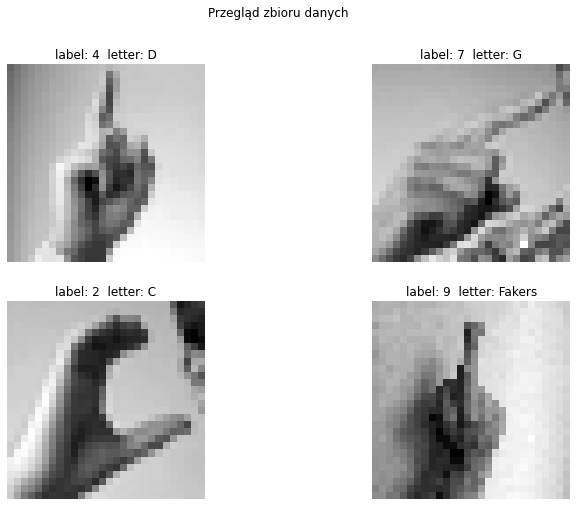

In [50]:
#plt.figure(figsize = (18,8))
fig,axe=plt.subplots(2,2,figsize = (12,8))
fig.suptitle('Przegląd zbioru danych')
axe[0,0].imshow(X_train[0].reshape(28,28),cmap='gray')
axe[0,0].set_title('label: 4  letter: D')
axe[0,0].axis('off')
axe[0,1].imshow(X_train[1].reshape(28,28),cmap='gray')
axe[0,1].set_title('label: 7  letter: G')
axe[0,1].axis('off')
axe[1,0].imshow(X_train[2].reshape(28,28),cmap='gray')
axe[1,0].set_title('label: 2  letter: C')
axe[1,0].axis('off')
axe[1,1].imshow(X_train[27530].reshape(28,28),cmap='gray')
axe[1,1].set_title('label: 9  letter: Fakers')
axe[1,1].axis('off')

c:\Users\Adam\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Częstotliwość występowania każdej z etykiet')

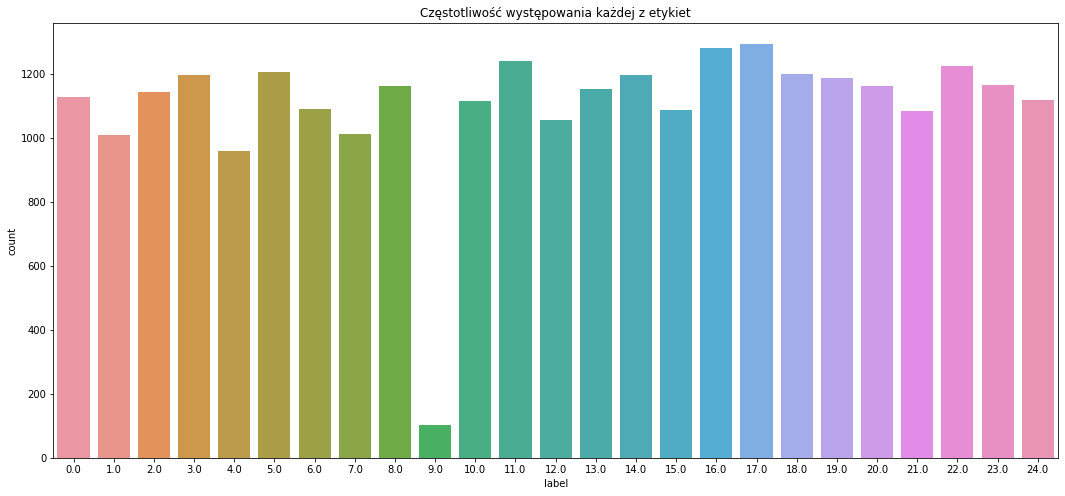

In [42]:
plt.figure(figsize = (18,8))
sns.countplot(train_label)
plt.title("Częstotliwość występowania każdej z etykiet")

# **Building the CNN Model**

The model consist of :
1. Three convolution layer each followed bt MaxPooling for better feature capture
2. A dense layer of 512 units
3. The output layer with 24 units for 24 different classes

**Convolution layers**

Conv layer 1 -- UNITS - 128  KERNEL SIZE - 5 * 5   STRIDE LENGTH - 1   ACTIVATION - ReLu

Conv layer 2 -- UNITS - 64   KERNEL SIZE - 3 * 3   STRIDE LENGTH - 1   ACTIVATION - ReLu

Conv layer 3 -- UNITS - 32   KERNEL SIZE - 2 * 2   STRIDE LENGTH - 1   ACTIVATION - ReLu




MaxPool layer 1 -- MAX POOL WINDOW - 3 * 3   STRIDE - 2

MaxPool layer 2 -- MAX POOL WINDOW - 2 * 2   STRIDE - 2

MaxPool layer 3 -- MAX POOL WINDOW - 2 * 2   STRIDE - 2

In [35]:
model=Sequential()
model.add(Conv2D(128,kernel_size=(5,5),
                 strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
model.add(Conv2D(64,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
          
model.add(Flatten())

**Dense and output layers**

In [36]:
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=25,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [37]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

**Trenowanie modelu**

Do trenowania wykorzystujemy wcześniej utworzony obiekt "train_datagen", który generuje dodatkowe obrazy(przesunięte, przybliożone, obrócone horyzontalnie lub wertykalnie). Ilość dodatkowych danych zależy od parametru "batch_size", przyjeliśmy wartość 200, która daje bardzo zadowalające wyniki podczas trenowania. Metoda fit potrzebuje informacji ile wynosi liczba epok przez które będzie uczył się model, przekazujemy także dane testowe w celu sprawdzenia efektywności modelu.

In [38]:
model.fit(train_datagen.flow(X_train,y_train,batch_size=200),
         epochs = 30,
          validation_data=(X_test,y_test),
          shuffle=1
         )

Epoch 1/30
138/138 [==============================] - 42s 296ms/step - loss: 2.9834 - accuracy: 0.1064 - val_loss: 2.2870 - val_accuracy: 0.2918
Epoch 2/30
138/138 [==============================] - 41s 297ms/step - loss: 2.2333 - accuracy: 0.2959 - val_loss: 1.5114 - val_accuracy: 0.5196
Epoch 3/30
138/138 [==============================] - 43s 312ms/step - loss: 1.6663 - accuracy: 0.4605 - val_loss: 1.0638 - val_accuracy: 0.6591
Epoch 4/30
138/138 [==============================] - 42s 306ms/step - loss: 1.3075 - accuracy: 0.5650 - val_loss: 0.9750 - val_accuracy: 0.6878
Epoch 5/30
138/138 [==============================] - 43s 312ms/step - loss: 1.0837 - accuracy: 0.6378 - val_loss: 0.7111 - val_accuracy: 0.7410
Epoch 6/30
138/138 [==============================] - 44s 315ms/step - loss: 0.9143 - accuracy: 0.6957 - val_loss: 0.5533 - val_accuracy: 0.7864
Epoch 7/30
138/138 [==============================] - 43s 311ms/step - loss: 0.7955 - accuracy: 0.7328 - val_loss: 0.4428 - val_ac

In [41]:
model.save("Model_25E.h5")

In [47]:
model = tf.keras.models.load_model("Model_25E.h5")

**Evaluating the model**

In [48]:
(ls,acc)=model.evaluate(x=X_test,y=y_test)

226/226 [==============================] - 3s 11ms/step - loss: 0.0448 - accuracy: 0.9889


In [49]:
print('MODEL ACCURACY = {}%'.format(acc*100))

MODEL ACCURACY = 98.89058470726013%


In [4]:
def getLetter(result):
    classLabels = { 0: 'A',
                    1: 'B',
                    2: 'C',
                    3: 'D',
                    4: 'E',
                    5: 'F',
                    6: 'G',
                    7: 'H',
                    8: 'I',
                    9: 'FAK',
                    10: 'K',
                    11: 'L',
                    12: 'M',
                    13: 'N',
                    14: 'O',
                    15: 'P',
                    16: 'Q',
                    17: 'R',
                    18: 'S',
                    19: 'T',
                    20: 'U',
                    21: 'V',
                    22: 'W',
                    23: 'X',
                    24: 'Y'}
    try:
        res = int(result)
        return classLabels[res]
    except:
        return "Error"

def keras_predict(model, image):
	pred_probab = model.predict(image)[0]
	pred_class = list(pred_probab).index(max(pred_probab))
	return max(pred_probab), pred_class

In [3]:
import cv2
import numpy as np
from PIL import Image
from keras import models
import time
from time import time
import tensorflow as tf  

In [6]:
cap = cv2.VideoCapture(0)

model = models.load_model('Model_25E.h5')


while True:

    ret, frame = cap.read()
    
    ##############################
    frame=cv2.flip(frame, 1)

    #define region of interest
    roi = frame[100:400, 320:620]
    #cv2.imshow('roi', roi)
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi = cv2.resize(roi, (28, 28), interpolation = cv2.INTER_AREA)
    
    cv2.imshow('roi scaled and gray', roi)
    copy = frame.copy()
    cv2.rectangle(copy, (320, 100), (620, 400), (255,0,0), 5)
    
    roi = roi.reshape(1,28,28,1) 
    roi = roi/255
    pred_probab, pred_class = keras_predict(model,roi)
     
    print(pred_probab*100)
        #print(X_train[np.argmax(Y_proba)])
        
    #wynik = np.argmax(Y_proba)
    litera = getLetter(pred_class)
    cv2.putText(copy, litera, (300 , 100), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 255, 0), 2)
    cv2.imshow('frame', copy)    
    
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        



99.95524287223816
99.95224475860596
99.95844960212708
99.95757937431335
99.95573163032532
99.95670914649963
99.95537400245667
99.95777010917664
99.95777010917664
99.95613694190979
99.95763897895813
99.94198083877563
99.94198083877563
99.93359446525574
99.9384880065918
99.94783997535706
99.94783997535706
99.93676543235779
99.94230270385742
99.93255138397217
99.93255138397217
99.94029998779297
99.94416832923889
99.94070529937744
99.94277358055115
99.94277358055115
99.94364380836487
99.93951320648193
99.93951320648193
99.94398951530457
99.94661211967468
99.93649125099182
99.94674324989319
99.94674324989319
99.93984699249268
99.93950128555298
99.93950128555298
99.94921684265137
99.94077682495117
99.90697503089905
99.90697503089905
99.8504638671875
99.77789521217346
99.6878981590271
99.6878981590271
95.09496092796326
59.18837785720825
77.37438082695007
77.37438082695007
94.8454201221466
97.96972870826721
97.95788526535034
97.95788526535034
98.1882393360138
98.76236915588379
98.8982498645782

93.00991296768188
93.00991296768188
91.8232262134552
75.38951635360718
98.77177476882935
98.77177476882935
90.11648297309875
98.66740703582764
99.82399940490723
99.82399940490723
99.86125230789185
99.52656030654907
99.52656030654907
99.73570108413696
95.69423198699951
97.05135822296143
97.05135822296143
95.06281614303589
94.95842456817627
94.95842456817627
94.7108507156372
94.55056190490723
94.69571113586426
94.64525580406189
94.64525580406189
95.32515406608582
94.4928765296936
95.03748416900635
94.76117491722107
94.76117491722107
89.6510660648346
50.7637619972229
50.7637619972229
93.891042470932
99.99828338623047
99.9618649482727
99.9618649482727
99.83142614364624
97.49178886413574
99.99136924743652
99.99136924743652
99.99754428863525
99.96846914291382
99.96846914291382
99.99998807907104
100.0
100.0
99.99967813491821
99.99666213989258
99.99990463256836
99.99990463256836
99.99818801879883
99.94087219238281
99.71644282341003
99.71644282341003
99.97599720954895
99.99985694885254
99.99996

43.74714195728302
34.209808707237244
35.167208313941956
41.07785522937775
43.27661395072937
41.4696604013443
40.06665050983429
44.74671185016632
48.44100773334503
57.93786644935608
53.99665832519531
53.11459302902222
62.388330698013306
63.874465227127075
59.488099813461304
58.33879113197327
64.4264280796051
64.40621614456177
64.10952806472778
66.70299768447876
58.374857902526855
58.715277910232544
60.28676629066467
57.726454734802246
51.72533392906189
37.280720472335815
49.492478370666504
38.786518573760986
43.180978298187256
46.79313898086548
42.44685471057892
36.11953854560852
35.06998121738434
34.55962836742401
35.24850904941559
35.32927334308624
35.75931191444397
37.87486553192139
39.99314606189728
33.81305634975433
39.13739025592804
46.89496457576752
30.837810039520264
31.46979808807373
46.777722239494324
49.5912104845047
51.416921615600586
40.87694585323334
41.400474309921265
42.7630215883255
42.542827129364014
46.54203653335571
49.590182304382324
52.78513431549072
53.35153937339

42.387595772743225
50.49380660057068
57.79852867126465
62.20964789390564
69.78535056114197
69.38986778259277
69.833904504776
71.78167700767517
74.53774213790894
74.20746088027954
71.29179239273071
70.67347168922424
66.98643565177917
66.23862385749817
60.71731448173523
67.18489527702332
67.84565448760986
64.00671601295471
65.44364094734192
54.72291707992554
56.269216537475586
62.043702602386475
67.97236800193787
69.22567486763
61.44217848777771
59.36505198478699
63.547688722610474
58.60320329666138
54.11023497581482
50.958454608917236
56.00481033325195
59.75033640861511
63.10049295425415
63.63893151283264
69.87298130989075
72.87664413452148
72.00849056243896
65.40378928184509
64.38891887664795
66.26038551330566
66.67289137840271
67.10360646247864
57.924288511276245
53.061532974243164
44.662100076675415
39.94454741477966
41.91592037677765
52.20932960510254
53.90867590904236
52.899688482284546
57.82493352890015
57.93111324310303
58.79625082015991
57.3910653591156
54.333239793777466
52.238

99.91249442100525
99.93174076080322
99.92246627807617
99.93749260902405
99.9455988407135
99.96716976165771
99.98250603675842
99.98524188995361
99.99346733093262
99.98643398284912
99.99327659606934
99.99791383743286
99.99943971633911
99.99932050704956
99.99949932098389
99.99979734420776
99.9996542930603
99.99682903289795
99.99666213989258
99.99829530715942
99.9987244606018
99.99784231185913
99.99774694442749
99.99809265136719
99.99810457229614
99.9979019165039
99.9987244606018
99.99933242797852
99.9995470046997
99.9997615814209
99.99980926513672
99.99973773956299
99.99926090240479
99.9982476234436
99.99783039093018
99.9968409538269
99.98791217803955
99.97047781944275
99.94636178016663
99.90400671958923
99.90400671958923
99.91374015808105
99.93564486503601
99.90174770355225
99.924635887146
99.9314546585083
99.94882345199585
99.953293800354
99.95226860046387
99.98332262039185
99.98666048049927
99.98863935470581
99.99510049819946
99.99510049819946
99.99552965164185
99.99727010726929
99.997

KeyboardInterrupt: 

In [ ]:
cap.release()
cv2.destroyAllWindows() 